# **Projet 7 : Indexations automatique d'image **
**Resnet50**

Par Adrien Aprile




Authentification :

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


gpg: keybox '/tmp/tmpsp421_mt/pubring.gpg' created
gpg: /tmp/tmpsp421_mt/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [3]:
#Installation des librairies :
!pip install humanize
!pip install GPUtil
!pip install livelossplot

Création du répertoire :

In [8]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [2]:
!ls

datalab  drive


In [4]:
import os
os.chdir("drive")
os.chdir("Colab Notebooks")
os.chdir("data-cnn-allrace")

Vérification de la mémoire disponible :

In [5]:
# memory footprint support libraries/code

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.4 GB  | Proc size: 140.8 MB
GPU RAM Free: 11438MB | Used: 1MB | Util   0% | Total 11439MB


Création des train et validation generator : 

In [6]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator, load_img

train_dir = './AAA Train'
validation_dir = './AAA Validation'

nTrain = 3600
nVal = 600
train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,5))
datagen = ImageDataGenerator(rescale=1./255)

from keras.applications.resnet50 import preprocess_input
train_datagen = ImageDataGenerator(rescale=1./255,vertical_flip=True,preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)

# Train générator classique sans data augmentation : 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    class_mode='categorical',
    shuffle=False
)

Using TensorFlow backend.


Found 3600 images belonging to 60 classes.
Found 600 images belonging to 60 classes.


Chargement du Resnet50 : 

In [7]:
# Test du Resnet : 
from keras import applications
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam

resnet = applications.ResNet50(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))
resnet.layers.pop()

for layer in resnet.layers[:-10]:
    layer.trainable = True

last = resnet.layers[-1].output
x = Dense(60, activation="softmax")(last)
finetuned_model = Model(resnet.input, x)
finetuned_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
#resnet.summary()

Entrainement du modèle + graph accuracy et logloss : 

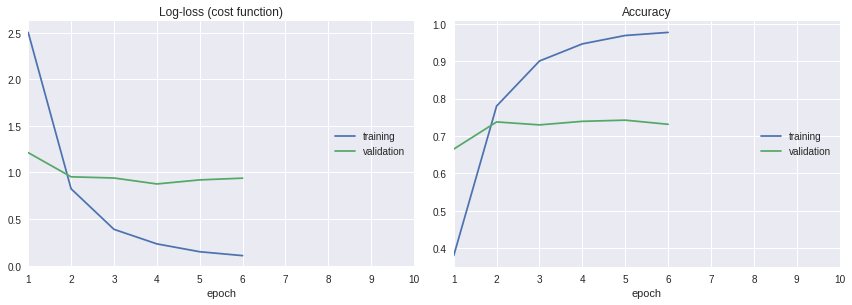

Epoch 7/10


In [0]:
from livelossplot import PlotLossesKeras
batch_size = 30
epochs = 10
history = finetuned_model.fit_generator(
    train_generator,
    epochs=epochs,
    steps_per_epoch=3600 // batch_size,
    validation_data = validation_generator,
    validation_steps=600 // batch_size,
    callbacks=[PlotLossesKeras()],
    verbose=2
)

Export du modèle et liste des classes  :

In [13]:
# Modèle et poids:
from keras.models import model_from_json
model_json = finetuned_model.to_json()
with open("modelresnet10.json", "w") as json_file:
    json_file.write(model_json)
#finetuned_model.save('modelresnet10.h5')
# serialize weights to HDF5
finetuned_model.save_weights("modelresnet10.h5")
print("Saved model to disk")

#Liste classes:
label_map = (train_generator.class_indices)
import pickle
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
      pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
save_obj(label_map,"labelmap")

Saved model to disk


Visualisation des résultats du modèles :

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = finetuned_model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
#print(confusion_matrix(validation_generator.classes, y_pred))
plt.imshow(confusion_matrix(validation_generator.classes, y_pred), interpolation='none',cmap="plasma")
plt.colorbar()
plt.grid(True)
plt.show()
print('Classification Report')
target_names = list(label_map.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

KeyboardInterrupt: ignored

Observation cas d'échec du modèle : 

In [20]:
#n02113712-miniature_poodle
print("prédiction :",y_pred[540:549])
print("valeur attendu :",validation_generator.classes[540:549])

prédiction : [32 32 54 53 55 54 54 53 53]
valeur attendu : [54 54 54 54 54 54 54 54 54]


In [52]:
print(list(label_map.keys())[list(label_map.values()).index(53)])
print(list(label_map.keys())[list(label_map.values()).index(32)])
print(list(label_map.keys())[list(label_map.values()).index(55)])

n02113624-toy_poodle
n02093859-Kerry_blue_terrier
n02113799-standard_poodle


Text(0.5,1,'miniature poodle')

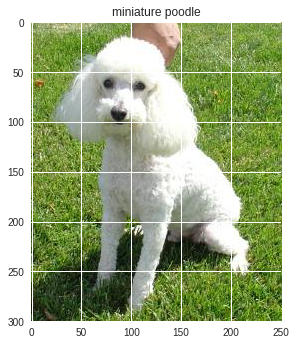

In [74]:
from PIL import Image
#os.chdir("AAA Validation")
#os.chdir("n02113712-miniature_poodle")
img = Image.open("n02113712_211.jpg")
plt.imshow(img)
plt.title("miniature poodle")

Text(0.5,1,'standard_poodle')

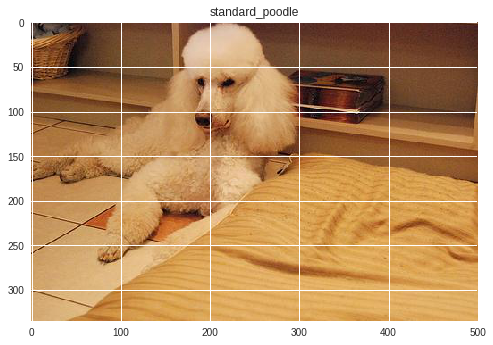

In [79]:
os.chdir("..")
os.chdir("n02113799-standard_poodle")
img = Image.open("n02113799_273.jpg")
plt.imshow(img)
plt.title("standard_poodle")

Text(0.5,1,'miniature poodle predict as Kerry Blue Terrier')

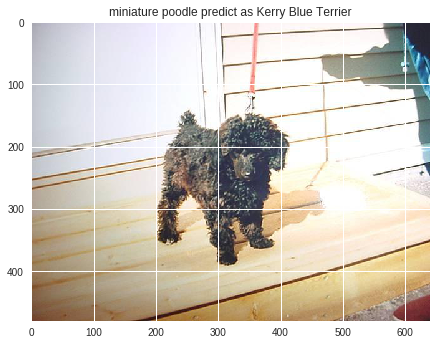

In [77]:
os.chdir("..")
os.chdir("n02113712-miniature_poodle")
img = Image.open("n02113712_112.jpg")
plt.imshow(img)
plt.title("miniature poodle predict as Kerry Blue Terrier")

Text(0.5,1,'Kerry Blue Terrier')

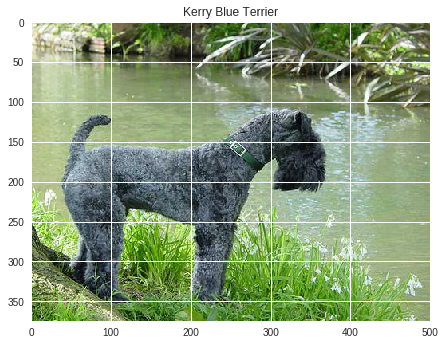

In [76]:
os.chdir("..")
os.chdir("n02093859-Kerry_blue_terrier")
img = Image.open("n02093859_10.jpg")
plt.imshow(img)
plt.title("Kerry Blue Terrier")
